## Подготовка форсинга для модели TEB по данным реанализа ERA5

In [1]:
import xarray as xr
import numpy as np
import os

### Чтение данных реанализа, конвертация в необходимый формат

In [20]:
in_path = r"ERA5_demo_data\Moscow 2022.nc" #путь  данным реанализа


point_crd = [55.5, 37.5] #координаты точки

ds = xr.open_dataset (in_path)
ds4point = ds.sel(latitude = point_crd[0], longitude = point_crd[1], method='nearest')

t  = ds4point['t2m']-273.15
td = ds4point['d2m']-273.15
p  = ds4point['sp']
        
E = 100 * 6.1*(10 ** (7.45*t  / (235+t)))
e = 100 * 6.1*(10 ** (7.45*td / (235+td)))
        
ds4point['rh2m'] = 100 * (e / E)

ds4point['Forc_TA']   = ds4point['t2m']
ds4point['Forc_QA'] = 0.623 * e / (p - 0.377 * e);

ds4point['Forc_WIND'] = np.sqrt (ds4point['u10']**2 + ds4point['v10']**2)
ds4point['Forc_DIR']  = np.mod(180+(180/np.pi) * np.arctan2(ds4point['u10'], ds4point['v10']), 360)
ds4point['Forc_DIR_SW'] = ds4point['fdir']/3600
ds4point['Forc_SCA_SW'] = ds4point['ssrd']/3600-ds4point['fdir']/3600
ds4point['Forc_LW'] = ds4point['strd']/3600
ds4point['Forc_PS'] = ds4point['sp']

is_rain_idx = np.where(ds4point['ptype'] < 2)[0] 
is_snow_idx = np.where(ds4point['ptype'] >= 2)[0] 

rain = np.zeros_like(ds4point['Forc_PS'])
snow = np.zeros_like(ds4point['Forc_PS'])

rain[is_rain_idx] = ds4point['tp'].to_numpy()[is_rain_idx]*1000/3600
snow[is_snow_idx] = ds4point['tp'].to_numpy()[is_snow_idx]*1000/3600


ds4point['Forc_RAIN'] = (ds4point['Forc_PS'].dims, rain)
ds4point['Forc_SNOW'] = (ds4point['Forc_PS'].dims, snow)
df4point = ds4point.to_dataframe()



<Axes: xlabel='time'>

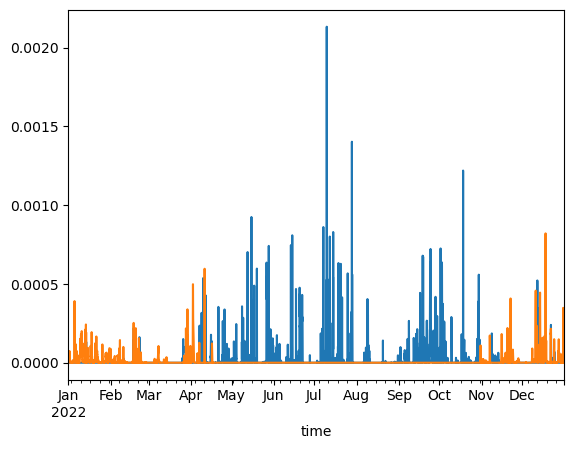

In [18]:
df4point['Forc_RAIN'].plot()
df4point['Forc_SNOW'].plot()

### Запись форсинга в текстовые файлы

In [23]:

save_dir = 'TEB_forcing/'
os.makedirs(save_dir, exist_ok=True)

for var in df4point.columns:
    if 'Forc_' in var:
        np.savetxt(save_dir + var + '.txt', df4point[var].to_numpy(), '%.5f')

df4point.to_csv (save_dir + 'full_df.csv')
    